In [10]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import pdb
from scipy import integrate
from scipy import special
import numpy as np
from cmath import *
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
from patch_geo_func import x_ep, y_ep
from sys import stdout
import warnings
np.seterr(invalid = 'raise', under = 'ignore', over = 'ignore')

{'divide': 'raise', 'over': 'ignore', 'under': 'ignore', 'invalid': 'raise'}

In [12]:
from assign_attr import *
from repel_system import *

In [28]:
LR_Pi_file = 'Ny-2-LR_Pi.bin'
#pos_file = 'server_data/test_3d_pos.bin'
#pos_file = 'server_data/test_low_3d_pos.bin'
#LR_Pi_file = 'Ny-2-LR_Pi.bin'
pos_file = 'ss_low_3d_pos.bin'
#pos_file = 'uniform_pos_file.bin'
OR_file = 'ORcolor.bin'
vpos_file = 'vpos.bin'
nblock = 32 #5209 #32
blockSize = 1024

a = 0.635
b = 96.7
k = np.sqrt(140)*0.873145
ecc = 2.0 # must consistent with the corresponding variables in parameter.m and macro.ipynb
p0 = -np.pi/2
p1 = np.pi/2

grid = np.array([64,104])*2
nx = grid[0]
ny = grid[1]
W = x_ep(ecc,0,k,a,b)
d = (1+2/nx)*W/nx
x = np.linspace(-W/nx, W+W/nx, nx)
W = W+2*W/nx
H = d*ny
y = np.linspace(-H/2, H/2, ny)
mMap = macroMap(nx, ny, x, y, nblock, blockSize, LR_Pi_file, pos_file, OR_file, a, b, k, ecc, p0, p1, False)

211x342, ecc-polar grid houses 32768 neurons
require 0.086 GB


calculate neurons' cortical distance to the nearest vertex in the grid
adjust neuron positions near the boundary
assign ocular dominance preference to neuron according to their position in the cortex
retract neurons from the OD-boundary to avoid extreme repelling force later


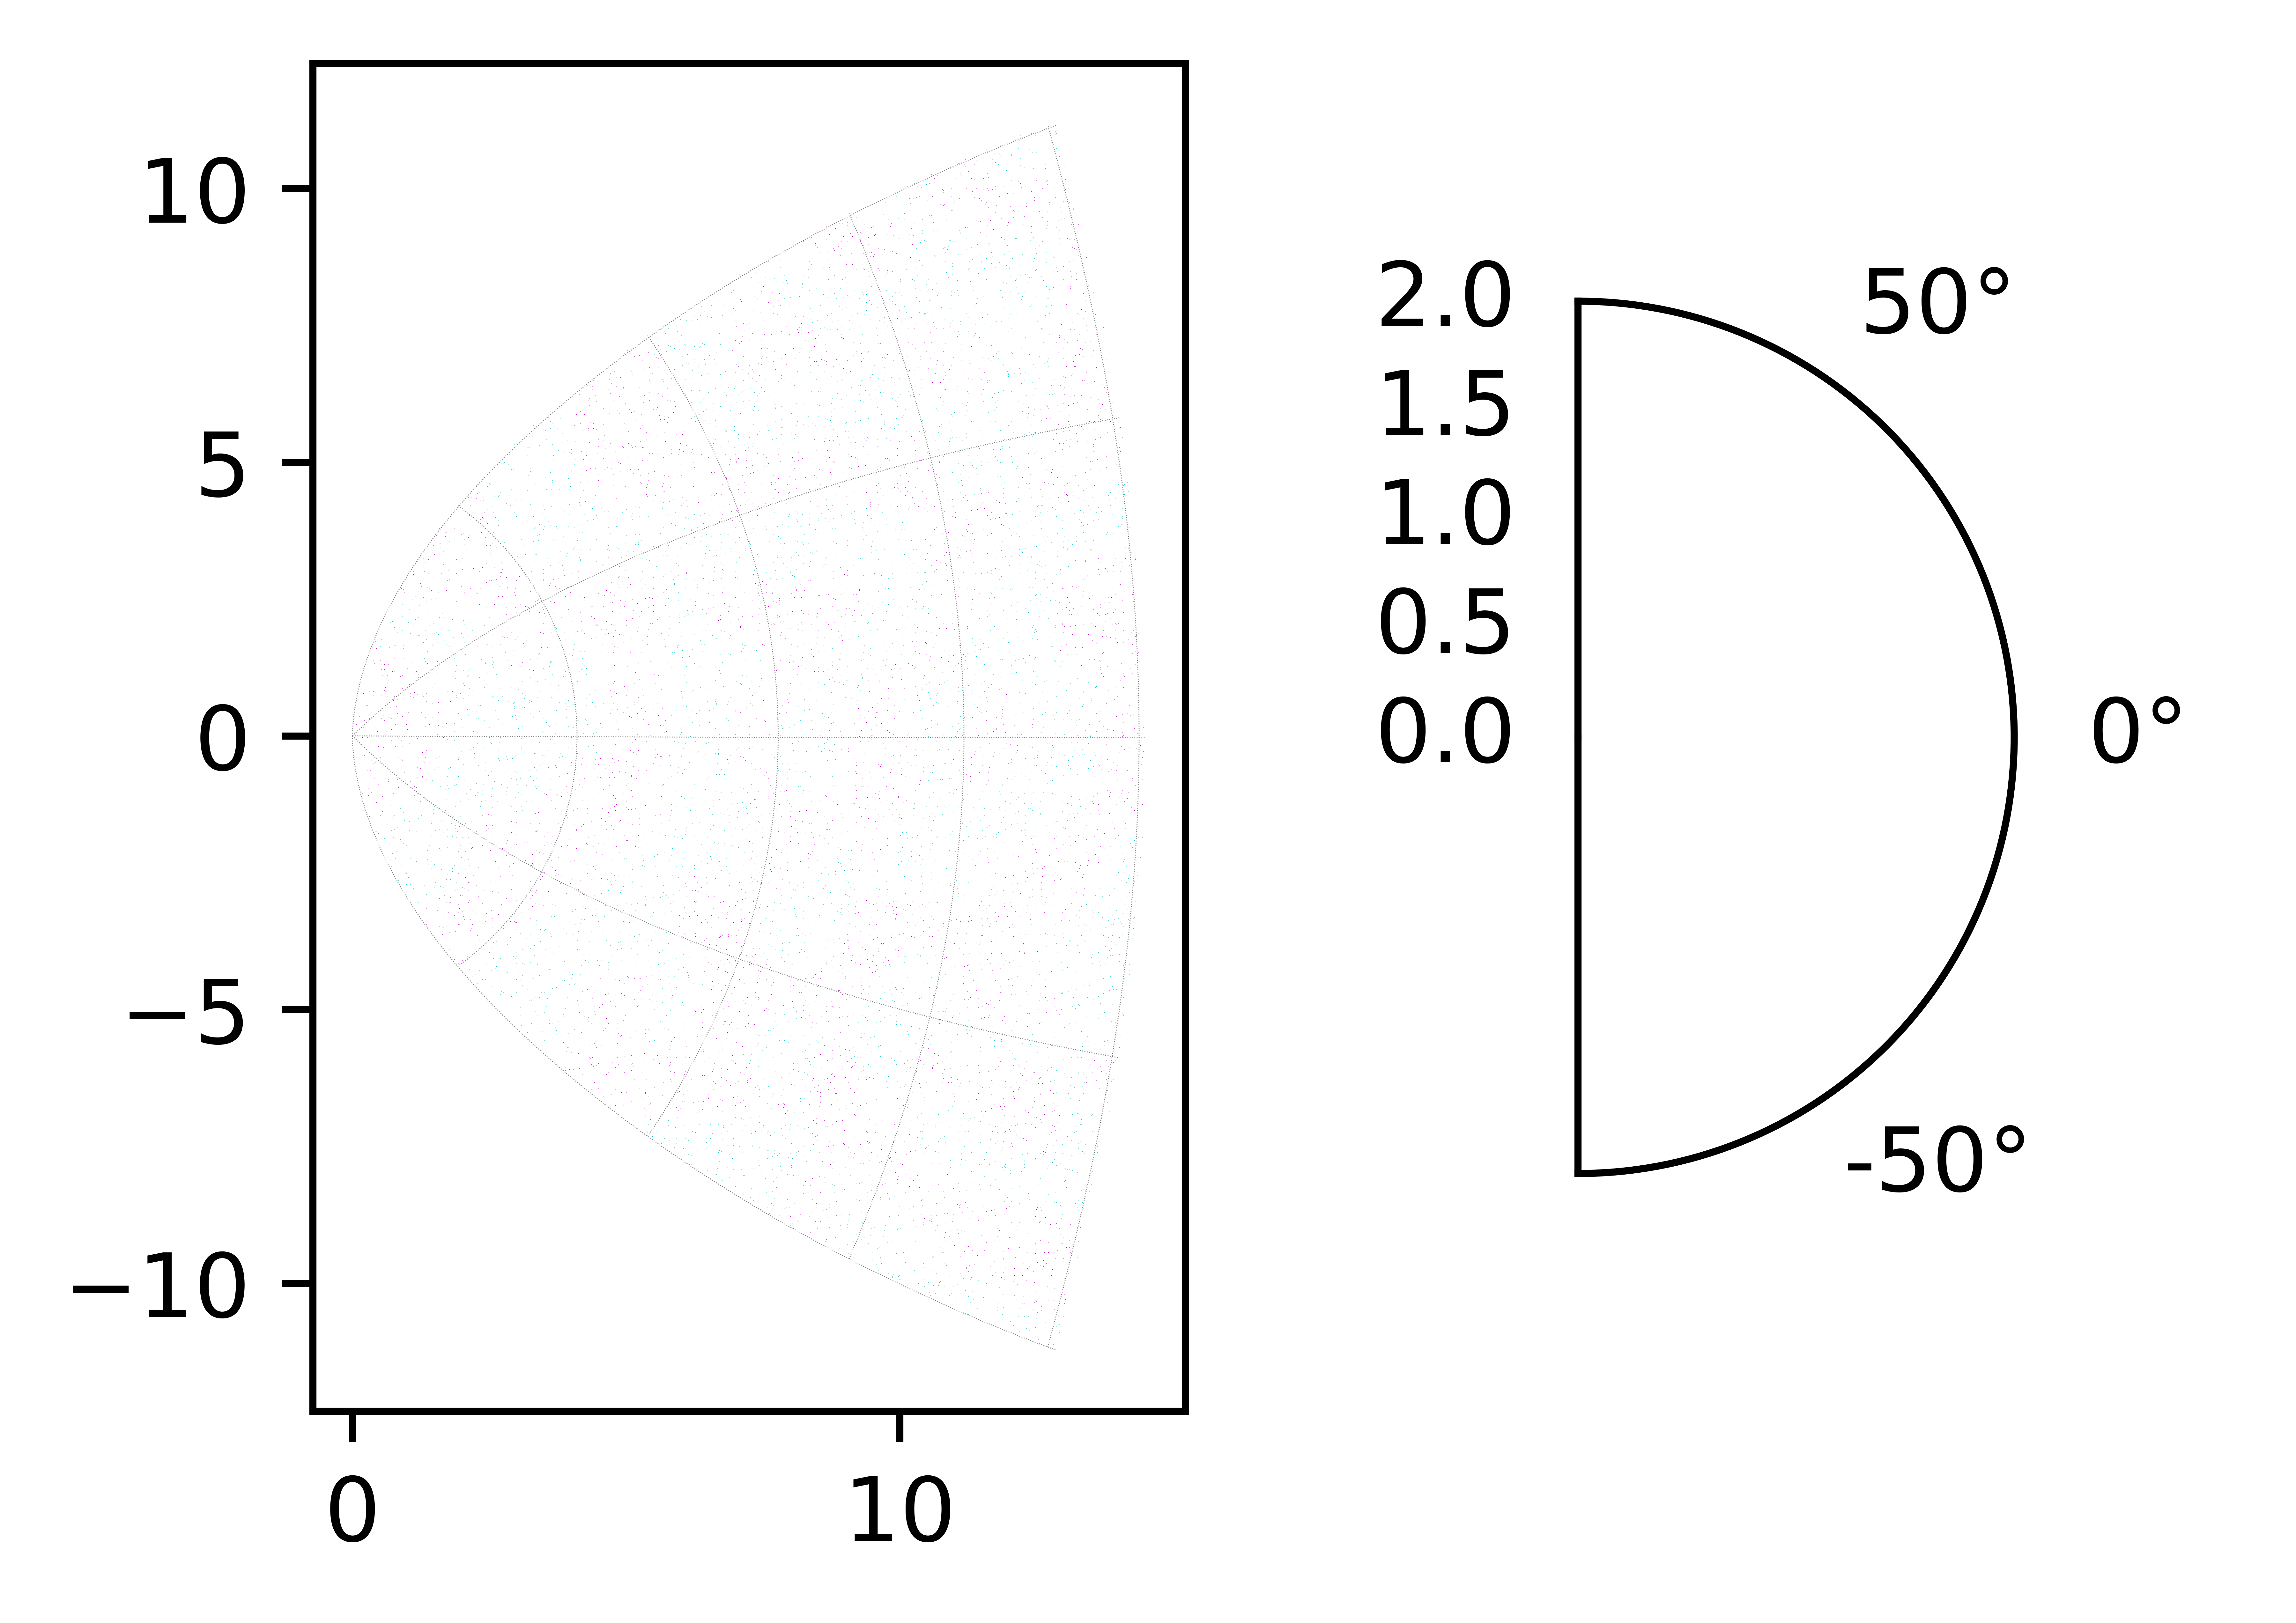

In [32]:
fig = plt.figure('macroMap',dpi=1000)
ax1 = fig.add_subplot(132, projection='polar')
ax2 = fig.add_subplot(131)
#mMap.assign_pos_OD0()
mMap.assign_pos_OD1()
mMap.pVFready = False
mMap.plot_map(ax1, ax2, fig.dpi, pltOD = True, pltVF = False, pltOP = False)
ax1.set_thetamin(p0/np.pi*180)
ax1.set_thetamax(p1/np.pi*180)
ax1.set_rmax(2.0)
ax1.set_rmin(0.0)
ax1.grid(False)
ax1.tick_params(labelleft=False, labelright=True,
               labeltop=False, labelbottom=True)
ax2.set_aspect('equal')
#ax1.set_yticks([0,0.5,1.00,1.50,2.00])
mMap.pODready = False
fig.savefig('sobol_test_low_density_uniform.png', dpi = 2000)

calculate neurons' cortical distance to the nearest vertex in the grid
adjust neuron positions near the boundary
assign ocular dominance preference to neuron according to their position in the cortex
retract neurons from the OD-boundary to avoid extreme repelling force later
smooth area: 108.30960013219963, 108.40218939774589
grid area: 107.99175513432431, 108.4736818958014, used in simulation
0.4169360473752022
characteristic length (inter-particle-distance)
particle:
a = 0.4362975897132483
b = 0.4362975897132483
k1 = 2
k2 = 1
cl = 0.08725951794264966
boundary:
a = 0.21814879485662414
b = 0.21814879485662414
k1 = 2
k2 = 1
cl = 0.08725951794264966
2278 boundary points and 16377 particles initialized
in units of grids (0.116,0.116):
    radius of the hexagon (0.753,0.755)
    radius of influence of particle (1.506,1.511)
    radius of influence of boundary (1.506,1.511)
    default limiting of displacement in one dt: (0.377, 0.378)
initialized
100.000%, 102 particles' displacement are l

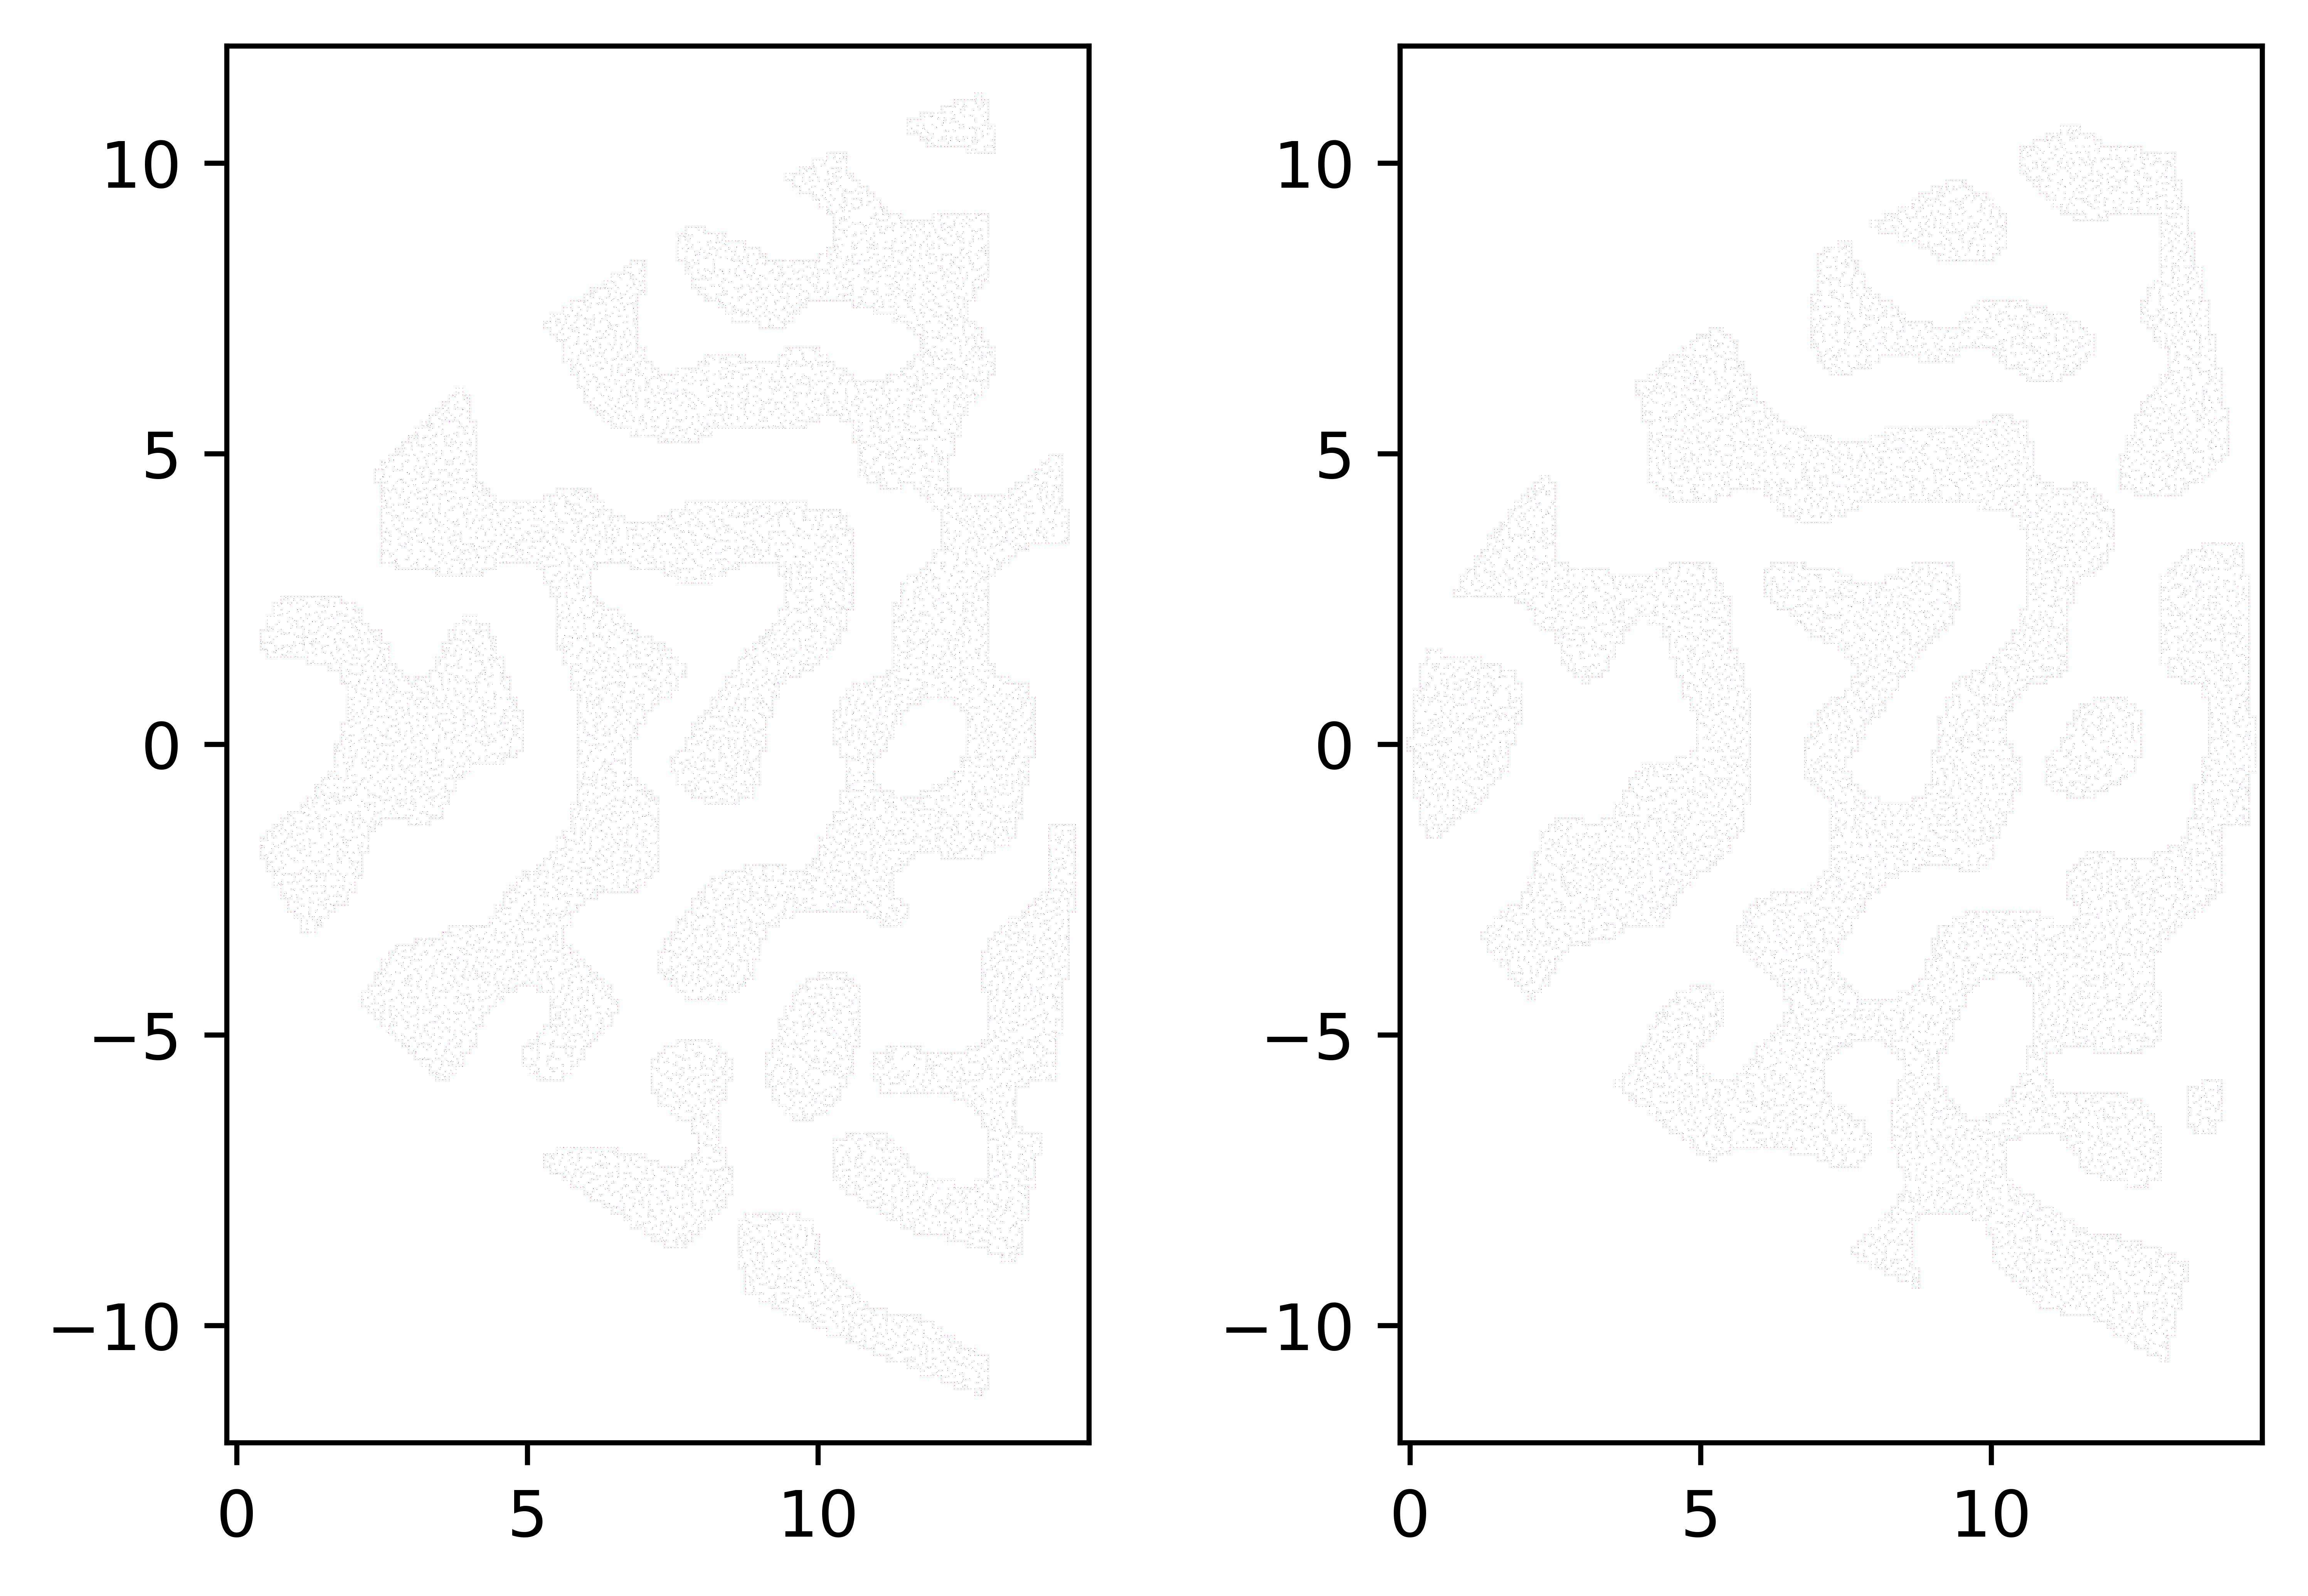

In [33]:
# spread uniformly
fig = plt.figure('pos', dpi = 600)
dx = mMap.x[1] - mMap.x[0]
dy = mMap.y[1] - mMap.y[0]
ax1 = fig.add_subplot(121)
ax1.set_xlim(mMap.x[0]-dx/2, mMap.x[-1]+dx/2)
ax1.set_ylim(mMap.y[0]-dy/2, mMap.y[-1]+dy/2)
ax1.set_aspect('equal')
ax2 = fig.add_subplot(122)
ax2.set_xlim(mMap.x[0]-dx/2, mMap.x[-1]+dx/2)
ax2.set_ylim(mMap.y[0]-dy/2, mMap.y[-1]+dy/2)
ax2.set_aspect('equal')
dt = np.power(2.0,-np.arange(13,14)).reshape(1,1)
dt = np.tile(dt,(1,1)).flatten()
oldpos, cL, cR, nL, nR = mMap.make_pos_uniform(dt, seed = 17482321, ax1 = ax1, ax2 = ax2)
fig.savefig('test_ss_density2.png', dpi = 2000)
mMap.save(pos_file = 'ss_pos_file.bin', OD_file = 'ss_od_file.bin')

In [20]:
%debug

> c:\users\gueux\patchv1\repel_system.py(439)get_turn()
    437         #else:
    438         #    r = np.max(np.abs(pos - self.pos[i,:,1]))
--> 439         assert(r > 0)
    440         return acc, r
    441 



ipdb>  print(r)


0


ipdb>  print(i)


1581


ipdb>  self.pos[i,0,1]


0.7558722487709859


ipdb>  self.pos[i,:,:]


array([[ 0.69793393,  0.75587225,  0.75587225],
       [-1.38632127, -1.38632127, -1.32855789]])


ipdb>  pos


array([ 1.00943066, -1.73199696])


ipdb>  pos-self.pos[i,:,1]


array([ 0.25355841, -0.34567569])


ipdb>  self.pos[i+1,:,:]


array([[ 2.43608356,  2.37814524,  2.37814524],
       [-1.38632127, -1.38632127, -1.44408466]])


ipdb>  self.pos[i-1,:,:]


array([[ 0.69793393,  0.63999561,  0.63999561],
       [-1.38632127, -1.38632127, -1.44408466]])


ipdb>  self.subgrid


array([0.11587664, 0.11552677])


ipdb>  0.75587225-0.6979


0.05797225000000006


ipdb>  self.rec


0.1748342501482791


ipdb>  self.subgrid


array([0.11587664, 0.11552677])


ipdb>  self.rec


0.1748342501482791


ipdb>  np.sign(pos[0] - self.pos[i,0,1]) != np.sign(pos[0] - self.pos[i,0,1] - np.copysign(self.rec, self.pos[i,0,1] - self.pos[i,0,turntype]))


False


ipdb>  np.sign(pos[1] - self.pos[i,1,1]) != np.sign(pos[1] - self.pos[i,1,1] - np.copysign(self.rec, self.pos[i,1,1] - self.pos[i,1,2-turntype]))


False


ipdb>  np.sign(pos[0] - self.pos[i,0,1]) != np.sign(pos[0] - self.pos[i,0,turntype])


False


ipdb>  np.sign(pos[1] - self.pos[i,1,1]) != np.sign(pos[1] - self.pos[i,1,2-turntype])


False


ipdb>  pos[1] - self.pos[i,1,1]


-0.34567568874776056


ipdb>  np.sign(pos[1] - self.pos[i,1,2-turntype]


*** SyntaxError: unexpected EOF while parsing


ipdb>  pos[1] - self.pos[i,1,2-turntype]


-0.4034390751591368


ipdb>  turntype


0


ipdb>  self.ro


*** AttributeError: 'rec_boundary' object has no attribute 'ro'


ipdb>  self.r0


0.1748342501482791


ipdb>  self.subgrid


array([0.11587664, 0.11552677])


ipdb>  self.pos[i,:,1]


array([ 0.75587225, -1.38632127])


ipdb>  self.pos[i+1,:,1]


array([ 2.37814524, -1.38632127])


ipdb>  self.pos[i+64,:,1]


array([13.6181795 , -0.69316064])


ipdb>  up


> c:\users\gueux\patchv1\repel_system.py(545)get_ahv()
    543 
    544     def get_ahv(self, i, pos):
--> 545         return self.get_turn(i, pos, 0)
    546 
    547     def get_avh(self, i, pos):



ipdb>  up


> c:\users\gueux\patchv1\repel_system.py(111)get_acc_update_limiting()
    109                 ds = self.boundary.pos[:,:,1] - pos[:,i].reshape(1,2)
    110                 ib = np.argmin(np.sum(np.power(ds, 2), axis = -1))
--> 111                 acc, limiting = self.boundary.get_acc[ib](ib, pos[:,i])
    112                 # update the limiting threshold
    113                 if limiting > 0:



ipdb>  up


> c:\users\gueux\patchv1\repel_system.py(78)initialize()
     76                 self.layer[0] = np.arange(self.nn)
     77 
---> 78         self.get_acc_update_limiting(self.layer[0])
     79         print('initialized')
     80         if self.layerSupplied is False:



ipdb>  up


> c:\users\gueux\patchv1\repel_system.py(574)simulate_repel()
    572     # test with default bound potential param
    573     system = repel_system(area, subgrid, pos, boundary, btype, boundary_param, particle_param, initial_v, nlayer = nlayer, layer = layer, soft_boundary = soft_boundary, soft_btype = soft_btype)
--> 574     system.initialize()
    575     if dt is not None:
    576         convergence = np.empty((dt.size,2))



ipdb>  up


> c:\users\gueux\patchv1\assign_attr.py(374)make_pos_uniform()
    372 
    373         oldpos = self.pos.copy()
--> 374         self.pos[:,pL], convergenceL, nlimitedL, _ = simulate_repel(areaL, self.subgrid, self.pos[:,pL], dt, self.OD_boundL, self.btypeL, boundary_param, particle_param, ax = ax1, seed = seed)
    375         self.pos[:,pR], convergenceR, nlimitedR, _ = simulate_repel(areaR, self.subgrid, self.pos[:,pR], dt, self.OD_boundR, self.btypeR, boundary_param, particle_param, ax = ax2, seed = seed)
    376         #convergenceR = 0



ipdb>  nx


*** NameError: name 'nx' is not defined


ipdb>  self.nx


128


ipdb>  self.ny


208


ipdb>  down


> c:\users\gueux\patchv1\repel_system.py(574)simulate_repel()
    572     # test with default bound potential param
    573     system = repel_system(area, subgrid, pos, boundary, btype, boundary_param, particle_param, initial_v, nlayer = nlayer, layer = layer, soft_boundary = soft_boundary, soft_btype = soft_btype)
--> 574     system.initialize()
    575     if dt is not None:
    576         convergence = np.empty((dt.size,2))



ipdb>  down


> c:\users\gueux\patchv1\repel_system.py(78)initialize()
     76                 self.layer[0] = np.arange(self.nn)
     77 
---> 78         self.get_acc_update_limiting(self.layer[0])
     79         print('initialized')
     80         if self.layerSupplied is False:



ipdb>  down


> c:\users\gueux\patchv1\repel_system.py(111)get_acc_update_limiting()
    109                 ds = self.boundary.pos[:,:,1] - pos[:,i].reshape(1,2)
    110                 ib = np.argmin(np.sum(np.power(ds, 2), axis = -1))
--> 111                 acc, limiting = self.boundary.get_acc[ib](ib, pos[:,i])
    112                 # update the limiting threshold
    113                 if limiting > 0:



ipdb>  down


> c:\users\gueux\patchv1\repel_system.py(545)get_ahv()
    543 
    544     def get_ahv(self, i, pos):
--> 545         return self.get_turn(i, pos, 0)
    546 
    547     def get_avh(self, i, pos):



ipdb>  down


> c:\users\gueux\patchv1\repel_system.py(439)get_turn()
    437         #else:
    438         #    r = np.max(np.abs(pos - self.pos[i,:,1]))
--> 439         assert(r > 0)
    440         return acc, r
    441 



ipdb>  self.pos[i,:,1]


array([ 0.75587225, -1.38632127])


ipdb>  self.pos[i+128,:,1]


array([7.12908755, 0.57763386])


ipdb>  self.pos[i+13,:,1]


array([ 3.30515837, -1.2707945 ])


ipdb>  self.pos[i+1,:,1]


array([ 2.37814524, -1.38632127])


ipdb>  self.pos[i:i+20,:,1]


array([[ 0.75587225, -1.38632127],
       [ 2.37814524, -1.38632127],
       [ 2.49402188, -1.38632127],
       [ 2.95752845, -1.38632127],
       [ 3.30515837, -1.38632127],
       [10.14188024, -1.38632127],
       [10.25775689, -1.38632127],
       [13.96580943, -1.38632127],
       [14.42931599, -1.38632127],
       [ 0.75587225, -1.2707945 ],
       [ 0.87174889, -1.2707945 ],
       [ 2.49402188, -1.2707945 ],
       [ 2.95752845, -1.2707945 ],
       [ 3.30515837, -1.2707945 ],
       [ 3.53691165, -1.2707945 ],
       [13.38642622, -1.2707945 ],
       [13.50230286, -1.2707945 ],
       [ 0.87174889, -1.15526773],
       [ 1.10350217, -1.15526773],
       [10.25775689, -1.15526773]])


ipdb>  self.pos[i+9,:,1]


array([ 0.75587225, -1.2707945 ])


ipdb>  self.pos[i,:,1]


array([ 0.75587225, -1.38632127])


ipdb>  pos


array([ 1.00943066, -1.73199696])


ipdb>  np.norm(pos-self.pos[i,:,1], axis=0)


*** AttributeError: module 'numpy' has no attribute 'norm'


ipdb>  np.linalg.norm(pos-self.pos[i,:,1], axis=0)


0.4286998357551666


ipdb>  np.linalg.norm(pos-self.pos[i+9,:,1], axis=0)


0.526307493718233


ipdb>  self.pos[i,:,1]


array([ 0.75587225, -1.38632127])


ipdb>  self.pos[i+9,:,1]


array([ 0.75587225, -1.2707945 ])


ipdb>  self.pos[i,:,:]


array([[ 0.69793393,  0.75587225,  0.75587225],
       [-1.38632127, -1.38632127, -1.32855789]])


ipdb>  q


In [ ]:
fig = plt.figure('convergence', dpi = 150)
ax1 = fig.add_subplot(121)
plt.errorbar(dt[1:], cL[1:,0], yerr = cL[1:,1], c='b', ls ='-', marker = '*')
plt.errorbar(dt[1:], cR[1:,0], yerr = cR[1:,1], c='r', ls ='-', marker = '*')
#ax3.set_ylim(-1,1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax2 = fig.add_subplot(122)
ax2.plot(dt[1:], nlimL[1:], '*')
ax2.plot(dt[1:], nlimR[1:], 'o')
ax2.set_xscale('log')
ax2.set_yscale('log')

In [ ]:
# spread for VF
fig = plt.figure('vposL', dpi = 600)
dx = mMap.x[1] - mMap.x[0]
dy = mMap.y[1] - mMap.y[0]
ax1 = fig.add_subplot(111)
ax1.set_xlim(mMap.x[0]-dx/2, mMap.x[-1]+dx/2)
ax1.set_ylim(mMap.y[0]-dy/2, mMap.y[-1]+dy/2)
ax1.set_aspect('equal') 
#dt = np.tile(dt,(nlayer,1)) * np.power(2.0, np.arange(nlayer)).reshape(nlayer,1)
#print(dt)
#dt = None
#vpos, cL, cR, nL, nR = mMap.spread_pos(dt, 10, seed = 17482321, ax1 = ax1, ax2 = ax2)
#del(vpos)
#del(vel)
#if 'vel' in locals():
#   assert('vpos' in locals())
#   vpos, cL, _, nL, _, vel = mMap.spread_pos(dt, nlayer, layer, layer_seq, pos = vpos, initial_v = vel, seed = 17482321, ax1 = ax1, ret_vel = True)
#else:
#layer_seq = np.arange(1)
#vpos, cL, _, nL, _, vel = mMap.spread_pos(dt, nlayer, layer_seq, pos = vpos, intial_v = vel, seed = 17482321, ax1 = ax1, useOldLayer = True)
#vpos, cL, _, nL, _, vel = mMap.spread_pos(dt, nlayer, layer_seq = layer_seq, pos = vpos, intial_v = vel, seed = 17482321, ax1 = ax1, ret_vel = True, useOldLayer = True)
#vpos, cL, _, nL, _, vel = mMap.spread_pos(dt, nlayer, layer_seq = layer_seq, seed = 17482321, ax1 = ax1, ret_vel = True, useOldLayer = False)
dt = np.power(2.0,-np.arange(5,6)).reshape(6-5,1)
dt = np.tile(dt,(1,100)).flatten()
#firstTime = False
#if firstTime is True:
#    L = mMap.LR.copy()
#    L[L > 0] = 0
#    L[L < 0] = 1
#    vposL = mMap.pos[:, mMap.ODlabel<0].copy()
#else:
with open('vposL.bin','rb') as f:
    vposL = np.fromfile(f).reshape(2, np.sum(mMap.ODlabel<0))
with open('L.bin','rb') as f:
    L = np.fromfile(f).reshape(mMap.Pi.shape)
    print(np.sum(L>0))
#spreaded = False
#while spreaded is False:
vposL, L, spreaded = mMap.spread_vpos(dt, vposL, L, seed = 17482321, ax = ax1)
print(np.sum(L>0))
with open('vposL.bin','wb') as f:
    vposL.tofile(f)
with open('L.bin','wb') as f:
    L.tofile(f)
fig.savefig('spread_VF_L.png', dpi = 2000)

16170
spread finished
characteristic length (inter-particle-distance) as twice the raidus of an hexagon 0.124
particle:
a = 0.1484444400530503
b = 0.1484444400530503
k1 = 2
k2 = 1
cl = 0.1484444400530503
boundary:
a = 0.09896296003536688
b = 0.09896296003536688
k1 = 2
k2 = 1
cl = 0.04948148001768344
640 boundary points and 16334 particles initialized
in units of grids (0.116,0.116):
    radius of the hexagon (1.068,1.071)
    radius of influence of particle (2.562,2.570)
    radius of influence of boundary (0.854,0.857)
    default limiting of displacement in one dt: (0.641, 0.642)
initialized
78.000%, 0 particles' displacement are limited, 0 particles freezed

NameError: name 'mMap' is not defined

In [ ]:
fig = plt.figure('vposR', dpi = 600)
ax1 = fig.add_subplot(111)
ax1.set_xlim(mMap.x[0]-dx/2, mMap.x[-1]+dx/2)
ax1.set_ylim(mMap.y[0]-dy/2, mMap.y[-1]+dy/2)
ax1.set_aspect('equal')
dt = np.power(2.0,-np.arange(5,8)).reshape(8-5,1)
dt = np.tile(dt,(1,10)).flatten()
firstTime = True
if firstTime is True:
    R = mMap.LR.copy()
    R[R < 0] = 0
    R[R > 0] = 1
    vposR = mMap.pos[:, mMap.ODlabel>0].copy()
else:
    with open('vposR.bin') as f:
        vposR = np.fromfile(f)
    with open('R.bin') as f:
        R = np.fromfile(f, dtype=int)
        print(R)
spreaded = False
while spreaded is False:
    vposR, R, spreaded = mMap.spread_vpos(dt, vposR, R, seed = 17482321, ax = ax1)
    with open('vposR.bin') as f:
        vposR.tofile(f)
    with open('R.bin') as f:
        R.tofile(f)
fig.savefig('spread_VF_R.png', dpi = 2000)

In [ ]:
vpos = np.empty((2,self.nn))
vpos[:, mMap.ODlabel > 0] = vposR
vpos[:, mMap.ODlabel < 0] = vposL
with open('vpos.bin') as f:
    vpos.tofile(f)

characteristic length (inter-particle-distance) as twice the raidus of an hexagon 0.097
particle:
a = 0.1169237370667417
b = 0.1169237370667417
k1 = 2
k2 = 1
cl = 0.1169237370667417
boundary:
a = 0.07794915804449448
b = 0.07794915804449448
k1 = 2
k2 = 1
cl = 0.03897457902224724
2278 boundary points and 16334 particles initialized
in units of grids (0.116,0.116):
    radius of the hexagon (0.841,0.843)
    radius of influence of particle (2.018,2.024)
    radius of influence of boundary (0.673,0.675)
    default limiting of displacement in one dt: (0.505, 0.506)
initialized
100.000%, 0 particles' displacement are limited, 0 particles freezedd

characteristic length (inter-particle-distance) as twice the raidus of an hexagon 0.097
particle:
a = 0.1169237370667417
b = 0.1169237370667417
k1 = 2
k2 = 1
cl = 0.1169237370667417
boundary:
a = 0.07794915804449448
b = 0.07794915804449448
k1 = 2
k2 = 1
cl = 0.03897457902224724
2278 boundary points and 16334 particles initialized
in units of grids

NameError: name 'vpos' is not defined

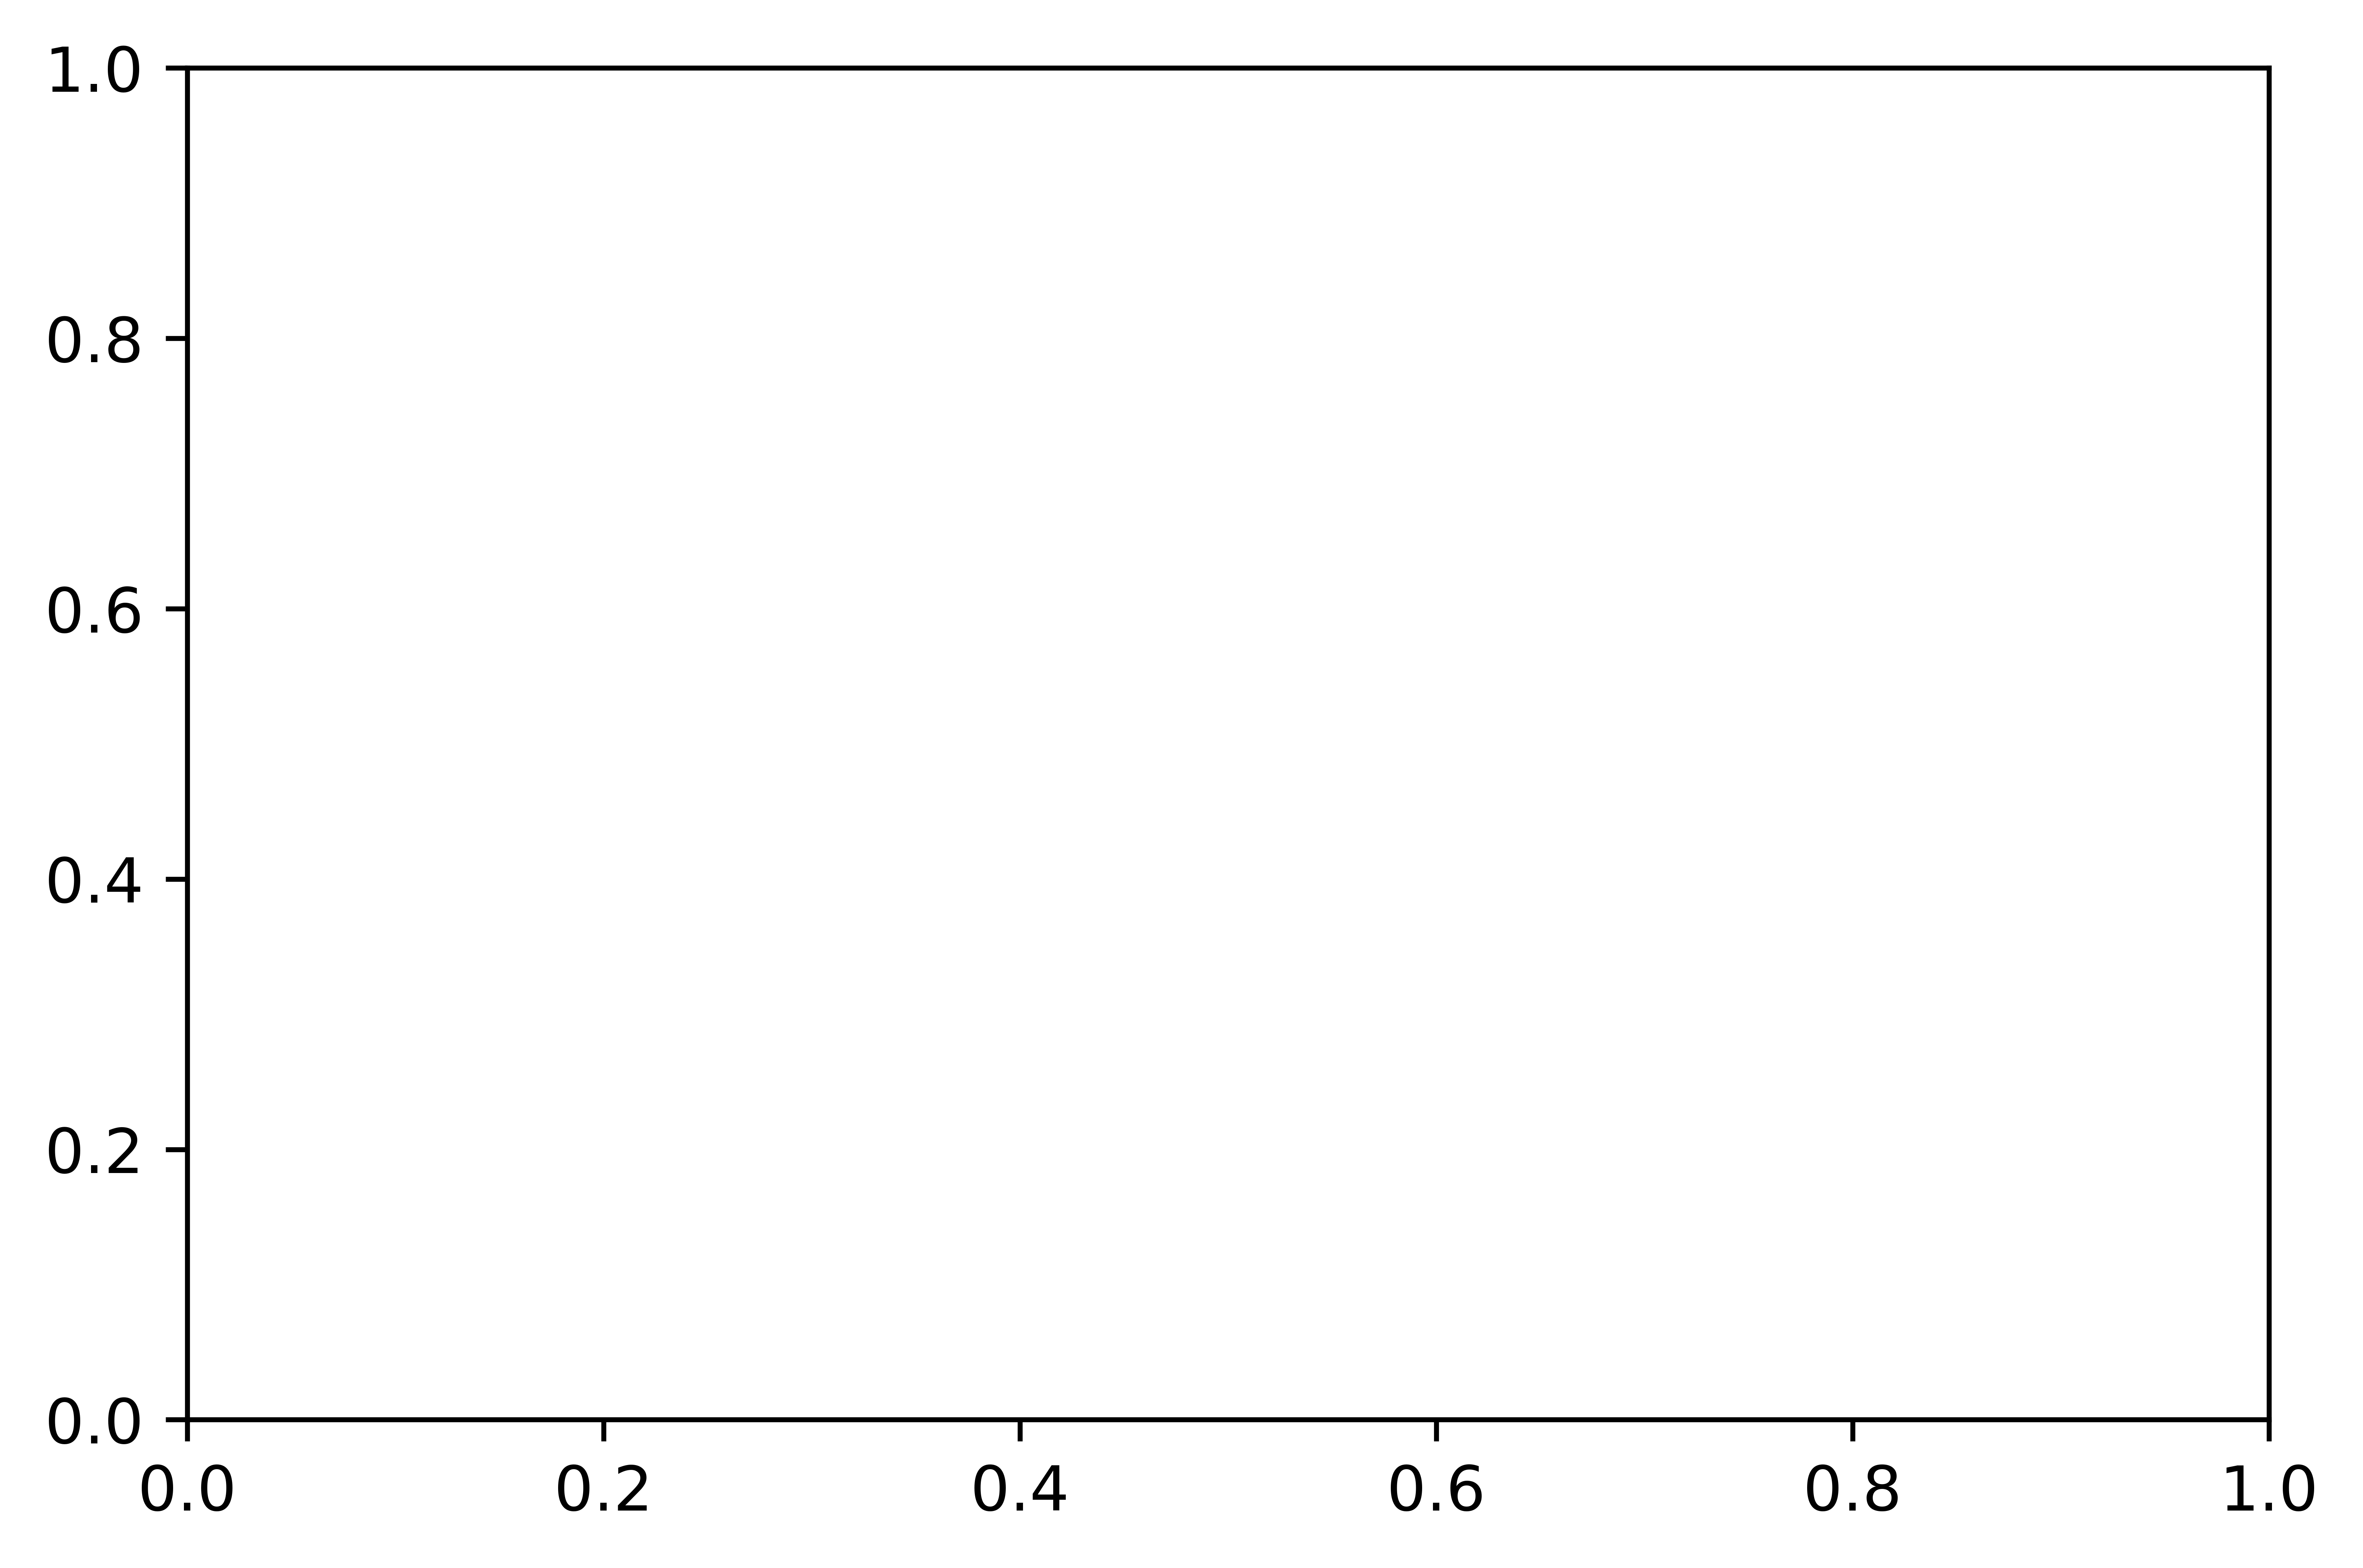

In [5]:
fig = plt.figure('endpoint', dpi = 600)
ax1 = fig.add_subplot(121)
ax1.plot(vposL[0,:], vposL[1,:], ',k')
ax2 = fig.add_subplot(122)
ax2.plot(vposR[0,:], vposR[1,:], ',k')
fig.savefig('spreaded.png', dpi = 2000)

In [11]:
%debug

> /home/wd554/local/miniconda3/envs/general/lib/python3.7/site-packages/numpy/lib/twodim_base.py(95)fliplr()
     93     m = asanyarray(m)
     94     if m.ndim < 2:
---> 95         raise ValueError("Input must be >= 2-d.")
     96     return m[:, ::-1]
     97 



ipdb>  up


> /scratch/wd554/patchV1/repel_system.py(56)initialize()
     54 
     55             print('\n')
---> 56             dis_range = np.fliplr(np.linspace(np.min(dis), np.max(dis), self.nlayer+1))
     57             for i in range(self.nlayer):
     58                 if i == self.nlayer-1:



ipdb>  dis.shape


(16334,)


ipdb>  self.nlayer


10


ipdb>  np.min(dis), np.max(dis)


(0.053565381399810263, 6.781148748371172)


ipdb>  np.linspace(np.min(dis), np.max(dis), self.nlayer+1)


array([0.05356538, 0.72632372, 1.39908205, 2.07184039, 2.74459873,
       3.41735706, 4.0901154 , 4.76287374, 5.43563207, 6.10839041,
       6.78114875])


ipdb>  q


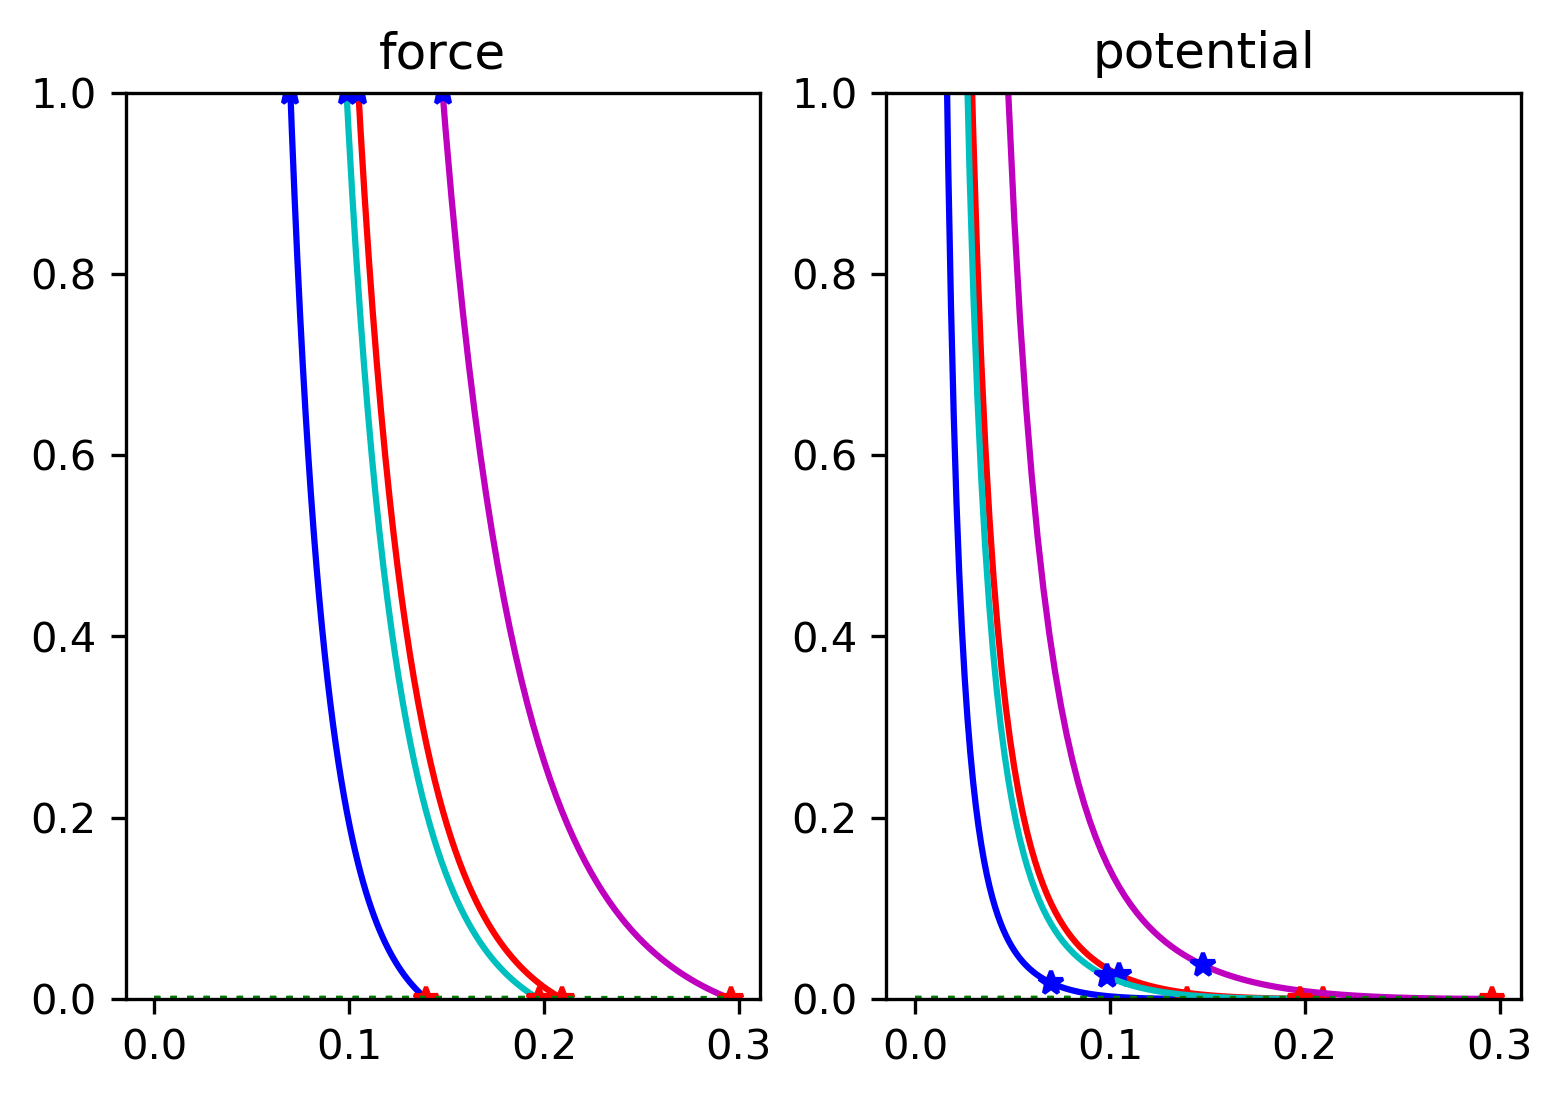

In [14]:
unit_hexagon_area = 6*np.sqrt(3)/4
area = mMap.subgrid[0] * mMap.subgrid[1] * np.sum(mMap.LR == 1)
cl = np.sqrt(3*(area/np.sum(mMap.ODlabel>0))/unit_hexagon_area)
p_scale = 1.2 # potential extension
b_scale = 0.8 # potential extension
pk1, pk2 = 2, 1
bk1, bk2 = 2, 1
a_particle = cl*p_scale
a_boundary = cl*b_scale
epsilon = 0.01
n = 100
top = 1
bottom = 0
fig = plt.figure('potential-force', dpi = 150)
ax1 = fig.add_subplot(121)
ax1.set_ylim(bottom, top)
ax2 = fig.add_subplot(122)
ax2.set_ylim(bottom, top)
potential = L_J_potiential(a_particle,a_particle,pk1,pk2,cl*p_scale)
potential.plot(ax1,ax2,'r')
#boundary:
potential = L_J_potiential(a_boundary,a_boundary,bk1,bk2,cl*b_scale)
potential.plot(ax1,ax2,'b')

area = mMap.subgrid[0] * mMap.subgrid[1] * np.sum(mMap.Pi > 0)
cl = np.sqrt(3*(area/np.sum(mMap.ODlabel>0))/unit_hexagon_area)
p_scale = 1.2 # potential extension
b_scale = 0.8 # potential extension
a_particle = cl*p_scale
a_boundary = cl*b_scale
potential = L_J_potiential(a_particle,a_particle,pk1,pk2,cl*p_scale)
potential.plot(ax1,ax2,'m')
#boundary:
potential = L_J_potiential(a_boundary,a_boundary,bk1,bk2,cl*b_scale)
potential.plot(ax1,ax2,'c')